In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc

adata = sc.read_h5ad("Visium_Human_Breast_Cancer_filtered_feature_bc_matrix.h5ad")

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

train_df = pd.read_csv("train_edges.csv")
valid_df = pd.read_csv("val_edges.csv")
test_df = pd.read_csv("test_edges.csv").drop('label', axis=1)

lr_pairs = pd.read_csv('celltalk_human_lr_pair.txt', sep='\t')

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)
print("Test shape:", test_df.shape)
print("LR Pairs shape:", lr_pairs.shape)

Train shape: (12000, 3)
Valid shape: (4000, 3)
Test shape: (4000, 2)
LR Pairs shape: (3398, 10)


In [2]:
X_train = np.load("X_train.npy")
X_valid = np.load("X_valid.npy")
X_test = np.load("X_test.npy")
y_train = train_df["label"]
y_valid = valid_df["label"]
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (12000, 20398), y_train shape: (12000,)
X_valid shape: (4000, 20398), y_valid shape: (4000,)
X_test shape: (4000, 20398)


In [3]:
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score


classifiers = {
    'Naive Bayes': GaussianNB(),
    'SVM': LinearSVC(random_state=50),
    'Logistic Regression': LogisticRegression(random_state=50),
    'Random Forest': RandomForestClassifier(random_state=50),
    'XGBoost': XGBClassifier(random_state=50),
    'LightGBM': LGBMClassifier(random_state=50, force_col_wise=True)
}


results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_valid, y_pred)
    results[name] = accuracy
    
    print(f"{name} accuracy: {accuracy:.4f}")
    print(classification_report(y_valid, y_pred, target_names=['negative', 'positive']))


Training Naive Bayes...
Naive Bayes accuracy: 0.7352
              precision    recall  f1-score   support

    negative       0.70      0.83      0.76      2000
    positive       0.79      0.64      0.71      2000

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.73      4000
weighted avg       0.74      0.74      0.73      4000


Training SVM...
SVM accuracy: 0.7722
              precision    recall  f1-score   support

    negative       0.79      0.74      0.76      2000
    positive       0.75      0.81      0.78      2000

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000


Training Logistic Regression...
Logistic Regression accuracy: 0.7970
              precision    recall  f1-score   support

    negative       0.81      0.77      0.79      2000
    positive       0.78      0.82      0.80      2000

    accuracy        

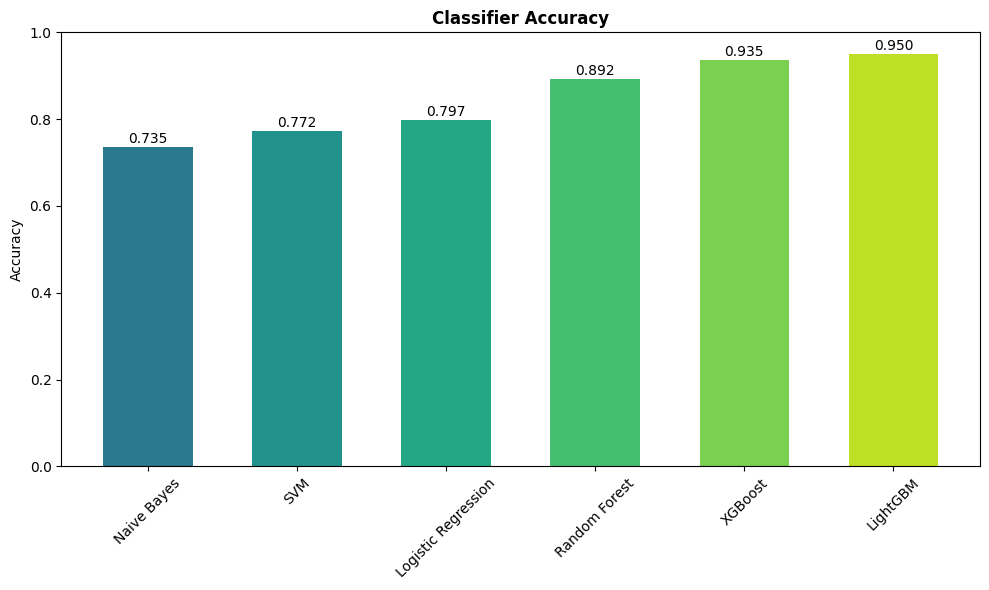

In [4]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))
models = list(results.keys())
accuracies = list(results.values())

colors = plt.cm.viridis(np.linspace(0.4, 0.9, len(models)))
plt.bar(models, accuracies, color=colors, width=0.6)
plt.title('Classifier Accuracy', fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()